# MNIST
This notebook introduces some aspects of the Keras API, demonstrated on the MNIST handwritten digit data set (a classic benchmark in computer vision).

In [1]:
%matplotlib inline
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import the MNIST data set (integrated in Keras)
from keras.datasets import mnist
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(42713) Label: 1


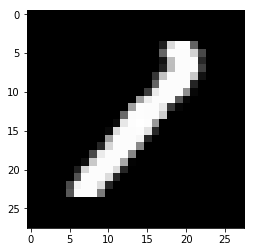

In [3]:
# Plot a random instance
i = np.random.choice(np.arange(x_train_mnist.shape[0]), 1)[0]
print('({}) Label: {}'.format(i, y_train_mnist[i]))
plt.imshow(x_train_mnist[i],cmap='gray')

In [4]:
# The input data consists of 28x28 images. However, models like logistic regression or regular neural networks
# do not understand 2D input. Therefore, we flatten the input images to convert them into 1D vectors
x_train_flat = x_train_mnist.reshape([60000, 28*28])
x_test_flat = x_test_mnist.reshape([10000, 28*28])

In [5]:
# Train a logistic (softmax) regression model on MNIST to demonstrate poor performance
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(multi_class='multinomial', solver='lbfgs',n_jobs=-1)
clf.fit(x_train_flat,y_train_mnist)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=-1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [6]:
# Print accuracy to evaluate the performance of logistic regression
from sklearn import metrics
print('Train accuracy: {}'.format(metrics.accuracy_score(y_train_mnist, clf.predict(x_train_flat))))
print('Test accuracy: {}'.format(metrics.accuracy_score(y_test_mnist, clf.predict(x_test_flat))))

Train accuracy: 0.9339166666666666
Test accuracy: 0.9255


In [7]:
# Build a neural network. Option 1: 1 layer (equivalent to logistic regression)
from keras.models import Sequential
from keras.layers import Dense, Activation
model = Sequential()
model.add(Dense(units=10, input_dim=28*28))
model.add(Activation('softmax'))

In [8]:
# Print a representation of the network architecture
# It's always a good idea to print this visualization of the network, to make sure we have built what we had in mind
# Also, it is important to know how many parameters we are going to have to estimate.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                7850      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Build a neural network
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential()

model.add(Dense(units=64, input_dim=28*28))
model.add(Activation('relu'))

model.add(Dense(units=10))
model.add(Activation('softmax'))

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                50240     
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
_________________________________________________________________
activation_3 (Activation)    (None, 10)                0         
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [12]:
def get_splits(X, y, ratio=0.1, cat=False):
    """
    Finds a random split of size ratio*size(data).
    Returns the corresponding splits of X and y.
    """
    val_ids = np.random.choice(np.arange(X.shape[0]), int(X.shape[0]*ratio), replace=False)
    train_ids = np.delete(np.arange(X.shape[0]), val_ids)
    x_train = X[train_ids,:]
    x_val = X[val_ids,:]
    if cat:
        y_train = y[train_ids,:]
        y_val = y[val_ids,:]
    else:
        y_train = y[train_ids]
        y_val = y[val_ids]                
    return x_train, y_train, x_val, y_val

In [13]:
# This is a very important step when training neural networks.
# Since the objective function is usually very complex, the optimization algorithm can take many iterations.
# In addition, if the network is sufficiently complex it can overfit the training set.
#
# This problem can be diminished by keeping aside a small split of the training data and periodically evaluating
# the loss of the model on it. 
x_train, y_train, x_val, y_val = get_splits(x_train_flat, y_train_mnist, ratio=0.05, cat=False)
print('Train: {}. Validation: {}'.format(x_train.shape, x_val.shape))

Train: (57000, 784). Validation: (3000, 784)


In [14]:
# To optimize objectives like categorical cross entropy (adequate for softmax output), we need to convert
# the labels to one-hot encoding (e.g. label 2 turns into [0,0,1,0,0,0,0,0,0,0])
from keras import utils
y_train = utils.to_categorical(y_train, num_classes=10)
y_val = utils.to_categorical(y_val, num_classes=10)
y_test = utils.to_categorical(y_test_mnist, num_classes=10)

In [15]:
# Example of one-hot encoded label
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [16]:
# Train the model for 10 epochs with full gradient
model.fit(x_train, y_train, epochs=10, batch_size=1024, validation_data=(x_val, y_val))

Train on 57000 samples, validate on 3000 samples
Epoch 1/10
57000/57000 [==============================] - 0s 8us/step - loss: 10.1148 - acc: 0.3680 - val_loss: 8.9890 - val_acc: 0.4397
Epoch 2/10
57000/57000 [==============================] - 0s 6us/step - loss: 7.1733 - acc: 0.5506 - val_loss: 6.3224 - val_acc: 0.6053
Epoch 3/10
57000/57000 [==============================] - 0s 6us/step - loss: 5.5204 - acc: 0.6539 - val_loss: 5.7707 - val_acc: 0.6393
Epoch 4/10
57000/57000 [==============================] - 0s 6us/step - loss: 5.3041 - acc: 0.6685 - val_loss: 5.6134 - val_acc: 0.6500
Epoch 5/10
57000/57000 [==============================] - 0s 6us/step - loss: 5.1907 - acc: 0.6754 - val_loss: 5.4666 - val_acc: 0.6583
Epoch 6/10
57000/57000 [==============================] - 0s 6us/step - loss: 4.7362 - acc: 0.7022 - val_loss: 4.4874 - val_acc: 0.7160
Epoch 7/10
57000/57000 [==============================] - 0s 6us/step - loss: 3.9906 - acc: 0.7487 - val_loss: 4.1683 - val_acc: 0.736

In [17]:
# Lists for monitoring progress
train_loss = []
val_loss = []

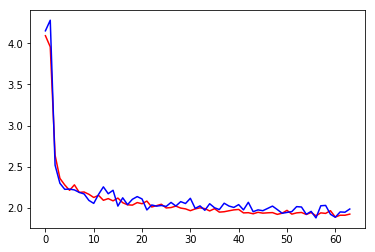

In [31]:
%matplotlib inline
# Minibatch gradient descent
# Here we try another approach. Usually, neural networks are not trained computing the full gradient,
# but only the gradient on a small batch of data (usually a not too large power of 2).
# This can help avoid overfitting, escape local minima and get more frequent progress reports
fig = plt.figure()
ax = fig.gca()

for i in range(50):
    history = model.fit(x_train, y_train, epochs=1, batch_size=128, verbose=0, validation_data=(x_val, y_val))
    
    train_loss.append(history.history['loss'])
    val_loss.append(history.history['val_loss'])
    
    ax.clear()    
    ax.plot(train_loss, color='red', label='Train')
    ax.plot(val_loss, color='blue', label='Validation')

    fig.canvas.draw()        

In [19]:
# Remember you can get the weights as an array, if you a re curious and want to take a look
model.get_weights()

[array([[-0.06582004,  0.07635766,  0.03274237, ..., -0.03097502,
         -0.07527821,  0.06294703],
        [ 0.02427165, -0.01465698,  0.034275  , ...,  0.01206943,
         -0.07522933,  0.07915502],
        [-0.03964326, -0.04427228, -0.07570299, ...,  0.01844554,
         -0.04757985,  0.00065866],
        ...,
        [ 0.06310674,  0.03993493, -0.01464113, ..., -0.04474762,
         -0.02967824,  0.01836045],
        [ 0.0668015 ,  0.081857  ,  0.05584352, ..., -0.00390657,
          0.08394095,  0.00908231],
        [-0.07942335, -0.08273802,  0.07657973, ...,  0.05031789,
          0.020321  , -0.03804052]], dtype=float32),
 array([-0.00155749, -0.01942528,  0.00392969,  0.02197055,  0.01212052,
         0.00223644, -0.03523205, -0.02496085, -0.01933135, -0.00308061,
        -0.0124211 , -0.0136145 , -0.00587517, -0.0293488 , -0.01147632,
        -0.00386952,  0.05121748, -0.00526512, -0.00656253, -0.00910826,
         0.00718794, -0.01570737, -0.02068973, -0.00792776,  0.022

In [20]:
# You can also easily save the model and its weights for later use
model.save('ann_mnist_64_relu.h5')
model.save_weights('my_model_weights.h5')

In [21]:
from sklearn import metrics
def evaluate(y, preds, classes=None):
    if not classes:
        classes = np.unique(y)
    """
    Given a set of labels y and predictions preds, computes precision, recall and F1.
    """
    for i in classes:
        preds_i = [1 if j==i else 0 for j in preds]
        y_i = [1 if j==i else 0 for j in y]
        print('Class {}:'.format(i))    
        print('Precision: {}'.format(metrics.precision_score(y_i, preds_i)))
        print('Recall: {}'.format(metrics.recall_score(y_i, preds_i)))
        print('F1: {}'.format(metrics.f1_score(y_i, preds_i)))
        print()

In [22]:
y_test_mnist.shape

(10000,)

In [32]:
# Evaluate the performance of the model
# First, we tell the model to give predictions for the test set
preds = model.predict(x_test_flat)
# Then, we convert the softmax predictions to label form
preds = list(map(lambda x: np.argmax(x), preds))
print(np.unique(preds))
# Now, print some classification metrics (the function above)
evaluate(y_test_mnist, preds)

[0 1 2 3 4 6 7 8 9]
Class 0:
Precision: 0.9263157894736842
Recall: 0.9877551020408163
F1: 0.9560493827160493

Class 1:
Precision: 0.9780701754385965
Recall: 0.9823788546255506
F1: 0.9802197802197802

Class 2:
Precision: 0.8834355828220859
Recall: 0.9767441860465116
F1: 0.927749654855039

Class 3:
Precision: 0.5890909090909091
Recall: 0.9623762376237623
F1: 0.7308270676691729

Class 4:
Precision: 0.945705824284304
Recall: 0.9755600814663951
F1: 0.9604010025062656

Class 5:
Precision: 0.0
Recall: 0.0
F1: 0.0

Class 6:
Precision: 0.9480122324159022
Recall: 0.9707724425887265
F1: 0.9592573491490459

Class 7:
Precision: 0.967196819085487
Recall: 0.9464980544747081
F1: 0.9567354965585053

Class 8:
Precision: 0.840952380952381
Recall: 0.9065708418891171
F1: 0.8725296442687748

Class 9:
Precision: 0.9681724845995893
Recall: 0.9345887016848364
F1: 0.9510842158345941



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


PREDICTION: 8


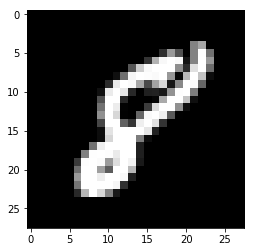

In [45]:
# Guess a random number from the test set
x = np.random.choice(np.arange(x_test_flat.shape[0]), 1)
x = x_test_flat[x]
img_x = x.reshape([28,28])
plt.imshow(img_x,cmap='gray')
print('PREDICTION: {}'.format(np.argmax(model.predict(x))))

PREDICTION: 4


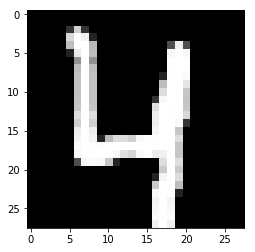

In [51]:
# Guess the number we just wrote by hand!
# Try it at home: draw a number on a 28x28 black background, using any Paint-like app. See if the model can guess it
import matplotlib.image as mpimg
img=mpimg.imread('number.png')
x = img[:,:,0].reshape([1,28*28])
plt.imshow(img,cmap='gray')
print('PREDICTION: {}'.format(np.argmax(model.predict(x))))